In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import xarray as xarr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Dec2018Components.csv')

In [4]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')

In [5]:
df.set_index(df['DateTime'], inplace=True, drop=True)

In [6]:
xr = xarr.Dataset.from_dataframe(df)

# Save to netCDF
xr.to_netcdf('testComponentsEvenNewer.nc')

In [7]:
ds = xarr.open_dataset('testComponentsEvenNewer.nc')

In [8]:
from windrose import WindroseAxes
from windrose import plot_windrose
import metpy.calc as mp
from metpy.units import units

In [9]:
ds['HorizontalSpeed'] = (ds['Speed_U']**2 + ds['Speed_V']**2)**(1/2)

In [10]:
ds = ds.assign(dircalc = (['DateTime'], mp.wind_direction(ds.Speed_U * units.meters /units.seconds, ds.Speed_V * units.meters /units.seconds).values))

In [11]:
ds['power'] = (0.5*0.52*1.225*np.pi*132*132*ds['HorizontalSpeed']**3)/1e6

In [12]:
#Add line for block averaging trick
line = ds.isel(DateTime = -1)
line = line.assign_coords(DateTime = line.DateTime.data + np.timedelta64(10, 'm'))
ds = xarr.concat((ds,line), dim = 'DateTime')

In [13]:
ds_30 = ds.resample(DateTime = '30min').mean()
ds_30 = ds_30.drop_isel(DateTime = -1)

In [14]:
ds_30_restricted = ds_30.where(((ds_30['HorizontalSpeed']>4) & (ds_30['HorizontalSpeed']<15)))

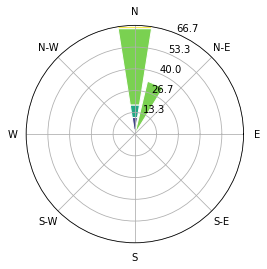

In [15]:
fig = plt.figure()
ax = plt.subplot(1, 1,1, projection="windrose")
ax.bar(ds_30_restricted['HorizontalSpeed'], ds_30_restricted['dircalc'], normed=True, edgecolor='white')

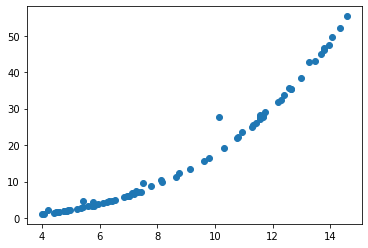

In [16]:
plt.scatter(ds_30_restricted['HorizontalSpeed'], ds_30_restricted['power'])